### Optimization for Machine Learning - Stochastic gradient methods

### Paris Dauphine University - PSL Research University

# IASD Project #5 : Stochastic BFGS methods 

January 19, 2024

Student: MERIGOT Jules

# Introduction

In [319]:
import numpy as np
import sklearn
from sklearn.datasets import load_svmlight_file
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

import numpy as np
from numpy.random import multivariate_normal, randn

from scipy.linalg import toeplitz
from scipy.linalg import svdvals
from scipy.linalg import norm
from scipy.optimize import check_grad
from scipy.optimize import fmin_l_bfgs_b

## Question 1

Let's select a training dataset for binary classification of the form $\{(a_i, y_i)\}_{i=1}^n$ with $a_i \in \mathbb{R}^d$ and $y_i \in (0,1)$. In order to load the dataset in Python, we'll use the routine `sklearn.datasets.load_svmlight_file` from the sickit-learn library.

Data can be found here: https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a9a

In [320]:
# Loading the data

A, y = load_svmlight_file("C:/Users/jules/OneDrive/Desktop/Opti_Project/stochastic-bfgs-methods/a7a.txt")
print(A.shape)

(16100, 122)


Below, I will make a heatmap to visualize the correlation matrix and the relationship between features. The correlation between features will be further explained and described in the report.

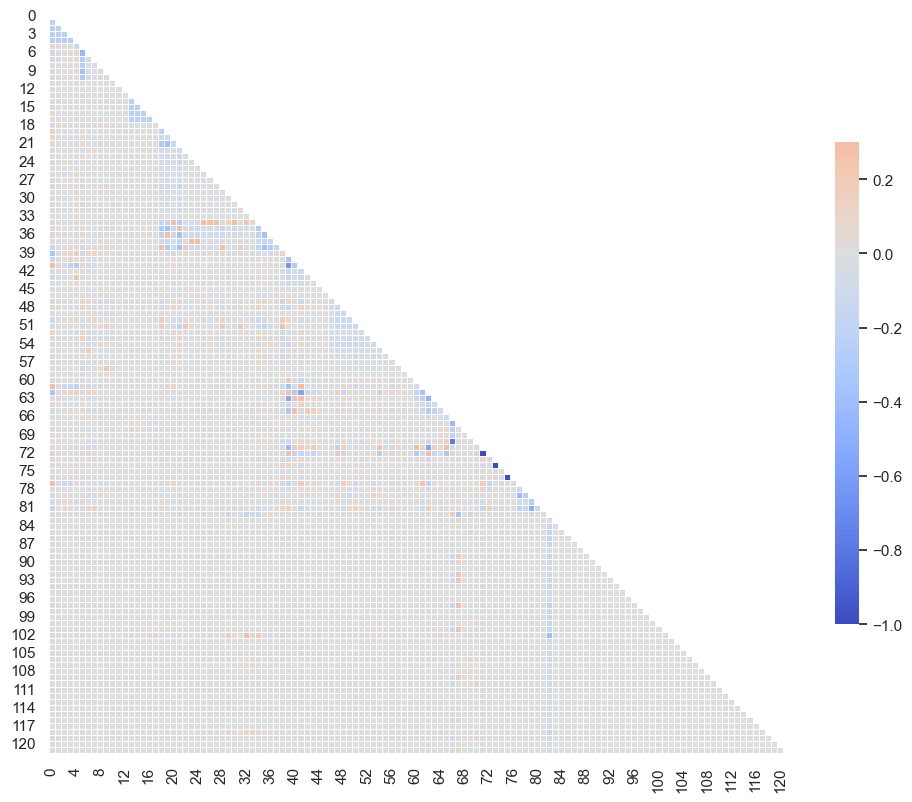

In [321]:
# Correlation Matrix heatmap

A_dense = A.toarray()
correlation_matrix = np.corrcoef(A_dense, rowvar=False)

sns.set(style="white")

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False, fmt=".2f")
plt.tight_layout()
plt.show()

## Question 2

Here, I will create my binary classification functions class, so that my problem functions can be utilized throughout this assignment. This is done by putting $f(x)$, $f_i(x)$, and $\nabla f_i(x)$ functions into python functions within my class. As a reminder, this binary classification problem is defined as:

Minimize the function $f(x)$, where $x \in \mathbb{R}^d$, defined as:
\begin{equation}
f(x) := \frac{1}{n} \sum_{i=1}^{n} f_i(x), \quad f_i(x) := \left( y_i - \frac{1}{1 + \exp(-\mathbf{a}_i^T \mathbf{x})} \right)^2. \tag{1}
\end{equation}

This problem is nonconvex in general. The function $t \mapsto \frac{1}{1+\exp(-t)}$ is called the sigmoid function.

For any $i = 1, \ldots, n$, the gradient of $f_i$ is given by:
\begin{equation}
\nabla f_i(\mathbf{x}) = -\frac{2 \exp(\mathbf{a}_i^T \mathbf{x}) \left( \exp(\mathbf{a}_i^T \mathbf{x})(y_i - 1) + y_i \right)}{(1 + \exp(\mathbf{a}_i^T \mathbf{x}))^3} \mathbf{a}_i. \tag{2}
\end{equation}


### Creating the Binary Classification Problem

Below, I create the binary classification object class with all the necessary functions for computing gradient descent and stochastic gradient, accompanied by a `lipgrad()` function containing the Lipschtiz constant for the gradient in order to calculate stepsizes.

In [322]:
# Create the Binary Classification object class

class BinClass(object):
    def __init__(self, A, y):
        self.A = A
        self.y = y
        self.n, self.d = A.shape
    
    # Lipschitz constant for the gradient
    def lipgrad(self):
        L = norm(self.A.toarray(), ord=2) ** 2 / (4. * self.n)
        return L
    
    # Objective value
    def fun(self, x):
        Ax = self.A.dot(x)
        f = (self.y - 1/(1+np.exp(-Ax))) ** 2
        return np.mean(f)
    
    # Partial objective value
    def f_i(self, i, x):
        Axi = self.A[i].dot(x)
        f_i = (self.y[i] - 1/(1+np.exp(-Axi))) ** 2
        return f_i
    
    # Full gradient computation
    def grad(self, x):
        Aix = self.A.dot(x)
        exp_Aix = np.exp(Aix)
        num = 2 * exp_Aix * (exp_Aix * (self.y - 1) + self.y)
        denom = (1 + exp_Aix) ** 3
        grad = -(num / denom) * self.A
        return grad / self.n

    # Partial gradient (of a single component f_i)
    def grad_i(self, i, x):
        Aix = self.A[i].dot(x).astype(float)
        exp_Aix = np.exp(Aix)
        num = 2 * exp_Aix * (exp_Aix * (self.y[i] - 1) + self.y[i])
        denom = (1 + exp_Aix) ** 3
        grad = -(num / denom) * self.A[i]
        return grad

Now I generate the problem instance by calling the class. Since this is a binary classification problem, I must take the logarithm of the feature vector.

In [323]:
# Generate the problem instance

# Taking the logarithm for binary classification
ylog = np.sign(y)

binclass_a7a = BinClass(A, ylog)

In order to be able to calculate the losses of my optimization methods, I have to compute an optimal solution for logistic regression for my binary classification problem using a second-order method. This will allow me to plot the objective value convergence later on and visualize the convergence of my algorithm depending on the optimization method used. Below, `x_min` is my target vector of weights and `f_min` is my target value which is used to calculate the loss.

In [324]:
# using L-BFGS-B to determine a solution for both problems

x_init = np.zeros(d)

# computing the optimal solution for logistic regression
x_min, f_min, _ = fmin_l_bfgs_b(binclass_a7a.fun, x_init, binclass_a7a.grad, args=(), pgtol=1e-30, factr =1e-30)
print(f_min)
print(norm(binclass_a7a.grad(x_min)))

0.9414365630729674
8.067317722119264e-10


### The Stochastic Gradient Descent Function

Below is the stochastic gradient descent (SGD) implementation as a function that will allow me to perform runs on my data with our binary classification problem class in order to conduct experiments with different stepsizes and batch sizes. This allows me to observe the convergence and losses of my different runs based on my chosen optimization method.

As recommended in the project instructions, this code was adapted from the stochastic gradient code provided during the course by Professor Clement Royer. All original credit for the function goes to him.

In [325]:
# Stochastic gradient implementation
def stoch_grad(x0, problem, xtarget, stepchoice=0, step0=1, n_iter=1000, nb=1, with_replace=False, verbose=True): 
    
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    
    # iterates distance to the minimum history
    normits = []
    
    # Lipschitz constant
    L = problem.lipgrad()
    
    # Number of samples
    n = problem.n
    
    # Initial value of current iterate  
    x = x0.copy()
    nx = norm(x)

    # Initialize iteration counter
    k=0
    
    # Current objective
    obj = problem.fun(x) 
    objvals.append(obj)
    # Current distance to the optimum
    nmin = norm(x-xtarget)
    normits.append(nmin)
    
    if verbose:
        # Plot initial quantities of interest
        print("Stochastic Gradient, batch size=",nb,"/",n)
        print(' | '.join([name.center(8) for name in ["iter", "fval", "normit"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))
    
    ################
    # Main loop
    while (k < n_iter and nx < 10**100):
        # Draw the batch indices
        ik = np.random.choice(n, nb, replace=with_replace) # Batch gradient
        # Stochastic gradient calculation
        sg = np.zeros(d)
        for j in range(nb):
            gi = problem.grad_i(ik[j],x)
            sg = sg + gi
        sg = (1/nb)*sg
            
        if stepchoice==0:
            x[:] = x - (step0/L) * sg
        elif stepchoice>0:
            sk = float(step0/((k+1)**stepchoice))
            x[:] = x - sk * sg
        
        nx = norm(x) #Computing the norm to measure divergence 

        obj = problem.fun(x)
        nmin = norm(x-xtarget)
        
       
        
        k += 1
        # Plot quantities of interest at the end of every epoch only
        if (k*nb) % n == 0:
            objvals.append(obj)
            normits.append(nmin)
            if verbose:
                print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))       
    
    # End of main loop
    #################
    
    # Plot quantities of interest for the last iterate (if needed)
    if (k*nb) % n > 0:
        objvals.append(obj)
        normits.append(nmin)
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))              
    
    # Outputs
    x_output = x.copy()
    
    return x_output, np.array(objvals), np.array(normits)

### Compare Gradient Descent and Stochastic Gradient

For Question 2, I will compare gradient descent and stochastic gradient on the given binary classification problem using constant stepsizes. By plotting the objective value convergence of both algorithms, I will be able to see how the training losses for both algorithms compare.

First, I use the the `stoch_grad()` function defined above to run the gradient descent and the stochastic gradient with a constant stepsize of 1/L (where L is the Lipschitz constant) and then with a constant stepsize of 0.01/L to visualize the difference. I will run this for 60 epochs.

In [297]:
# Compare implementations of gradient descent and stochastic gradient with constant stepsize

nb_epochs = 120
n = binclass_a7a.n
nbset = 1
x0 = np.zeros(binclass_a7a.d)

# Gradient descent with constant stepsize 1/L
x_gd1, obj_gd1, nits_gd1 = stoch_grad(x0, binclass_a7a, x_min, stepchoice=0, step0=1, n_iter=nb_epochs, nb=n)

# Stochastic gradient with constant stepsize 1/L
x_sg1, obj_sg1, nits_sg1 = stoch_grad(x0, binclass_a7a, x_min, stepchoice=0, step0=1, n_iter=int(nb_epochs*n/nbset), nb=1)

# Gradient descent with constant stepsize 0.01/L
x_gd2, obj_gd2, nits_gd2 = stoch_grad(x0, binclass_a7a, x_min, stepchoice=0, step0=0.1, n_iter=nb_epochs, nb=n)

# Stochastic gradient with constant stepsize 0.01/L
x_sg2, obj_sg2, nits_sg2 = stoch_grad(x0, binclass_a7a, x_min, stepchoice=0, step0=0.1, n_iter=int(nb_epochs*n/nbset), nb=1)

Stochastic Gradient, batch size= 16100 / 16100
  iter   |   fval   |  normit 
       0 | 1.76e+00 | 2.10e+02
       1 | 1.13e+00 | 2.10e+02
       2 | 1.08e+00 | 2.10e+02
       3 | 1.06e+00 | 2.10e+02
       4 | 1.05e+00 | 2.10e+02
       5 | 1.04e+00 | 2.10e+02
       6 | 1.03e+00 | 2.10e+02
       7 | 1.03e+00 | 2.10e+02
       8 | 1.02e+00 | 2.10e+02
       9 | 1.02e+00 | 2.10e+02
      10 | 1.02e+00 | 2.10e+02
      11 | 1.02e+00 | 2.10e+02
      12 | 1.02e+00 | 2.10e+02
      13 | 1.02e+00 | 2.10e+02
      14 | 1.01e+00 | 2.10e+02
      15 | 1.01e+00 | 2.10e+02
      16 | 1.01e+00 | 2.10e+02
      17 | 1.01e+00 | 2.10e+02
      18 | 1.01e+00 | 2.10e+02
      19 | 1.01e+00 | 2.10e+02
      20 | 1.01e+00 | 2.10e+02
      21 | 1.01e+00 | 2.10e+02
      22 | 1.01e+00 | 2.10e+02
      23 | 1.01e+00 | 2.10e+02
      24 | 1.01e+00 | 2.10e+02
      25 | 1.01e+00 | 2.10e+02
      26 | 1.01e+00 | 2.10e+02
      27 | 1.01e+00 | 2.10e+02
      28 | 1.01e+00 | 2.10e+02
      29 | 1.01e+00 | 2

Now, I will use the objective values collected from my runs to plot the the convergence of the runs. Below is the plot of the comparison between gradient descent and stochastic gradient using a constant stepsize of 1/L and then 0.01/L. The x-axis is in epochs for 1 iteration of gradient descent, and the y-axis is in terms of the recorded objective value of the optimization methods on a logarithmic scale.

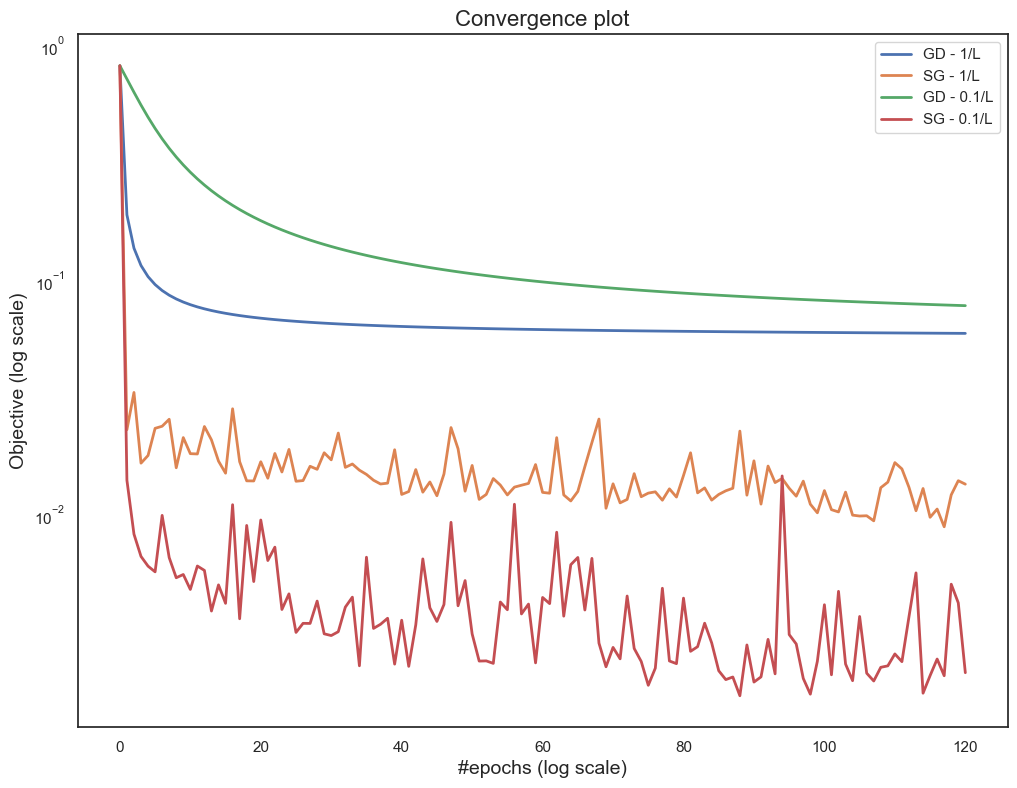

In [298]:
# plot comparison of GD/SG with the same stepsize

plt.figure(figsize=(12, 9))
plt.semilogy(obj_gd1-f_min, label="GD - 1/L", lw=2)
plt.semilogy(obj_sg1-f_min, label="SG - 1/L", lw=2)
plt.semilogy(obj_gd2-f_min, label="GD - 0.1/L", lw=2)
plt.semilogy(obj_sg2-f_min, label="SG - 0.1/L", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()

## Question 3 - Batch Stochastic Gradient

Next, I will conduct experiments with the batch stochastic gradient optimization method, using a fixed batch size throughout. For this, I will try 3 different batch sizes and observe which value emerges as the best one for my binary classification problem.

In [251]:
# Batch stochastic gradient

# testing several values for the batch size using the same epoch budget

# test for 60 epochs
nb_epochs = 120
n = binclass_a7a.n
x0 = np.zeros(binclass_a7a.d)
replace_batch=False

# batch size n/677 = 25
nbset=int(n/644)
x_a, obj_a, nits_a = stoch_grad(x0, binclass_a7a, x_min, stepchoice=0, step0=0.1, n_iter=int(nb_epochs*n/nbset), nb=nbset, with_replace=replace_batch)

# batch size n/230 = 70
nbset=int(n/230)
x_b, obj_b, nits_b = stoch_grad(x0, binclass_a7a, x_min, stepchoice=0, step0=0.1, n_iter=int(nb_epochs*n/nbset), nb=nbset, with_replace=replace_batch)

# batch size n/70 = 230
nbset=int(n/70)
x_c, obj_c, nits_c = stoch_grad(x0, binclass_a7a, x_min, stepchoice=0, step0=0.1, n_iter=int(nb_epochs*n/nbset), nb=nbset, with_replace=replace_batch)

Stochastic Gradient, batch size= 25 / 16100
  iter   |   fval   |  normit 
       0 | 1.76e+00 | 5.03e+02
     644 | 1.00e+00 | 5.02e+02
    1288 | 1.00e+00 | 5.02e+02
    1932 | 9.94e-01 | 5.02e+02
    2576 | 9.77e-01 | 5.02e+02
    3220 | 9.69e-01 | 5.02e+02
    3864 | 9.65e-01 | 5.02e+02
    4508 | 9.62e-01 | 5.02e+02
    5152 | 9.60e-01 | 5.03e+02
    5796 | 9.58e-01 | 5.03e+02
    6440 | 9.57e-01 | 5.03e+02
    7084 | 9.56e-01 | 5.03e+02
    7728 | 9.55e-01 | 5.03e+02
    8372 | 9.54e-01 | 5.03e+02
    9016 | 9.54e-01 | 5.03e+02
    9660 | 9.53e-01 | 5.03e+02
   10304 | 9.53e-01 | 5.03e+02
   10948 | 9.52e-01 | 5.03e+02
   11592 | 9.52e-01 | 5.03e+02
   12236 | 9.52e-01 | 5.03e+02
   12880 | 9.51e-01 | 5.03e+02
   13524 | 9.52e-01 | 5.03e+02
   14168 | 9.51e-01 | 5.03e+02
   14812 | 9.50e-01 | 5.03e+02
   15456 | 9.51e-01 | 5.03e+02
   16100 | 9.50e-01 | 5.03e+02
   16744 | 9.50e-01 | 5.03e+02
   17388 | 9.50e-01 | 5.03e+02
   18032 | 9.50e-01 | 5.03e+02
   18676 | 9.49e-01 | 5.03

0.9455115194623203


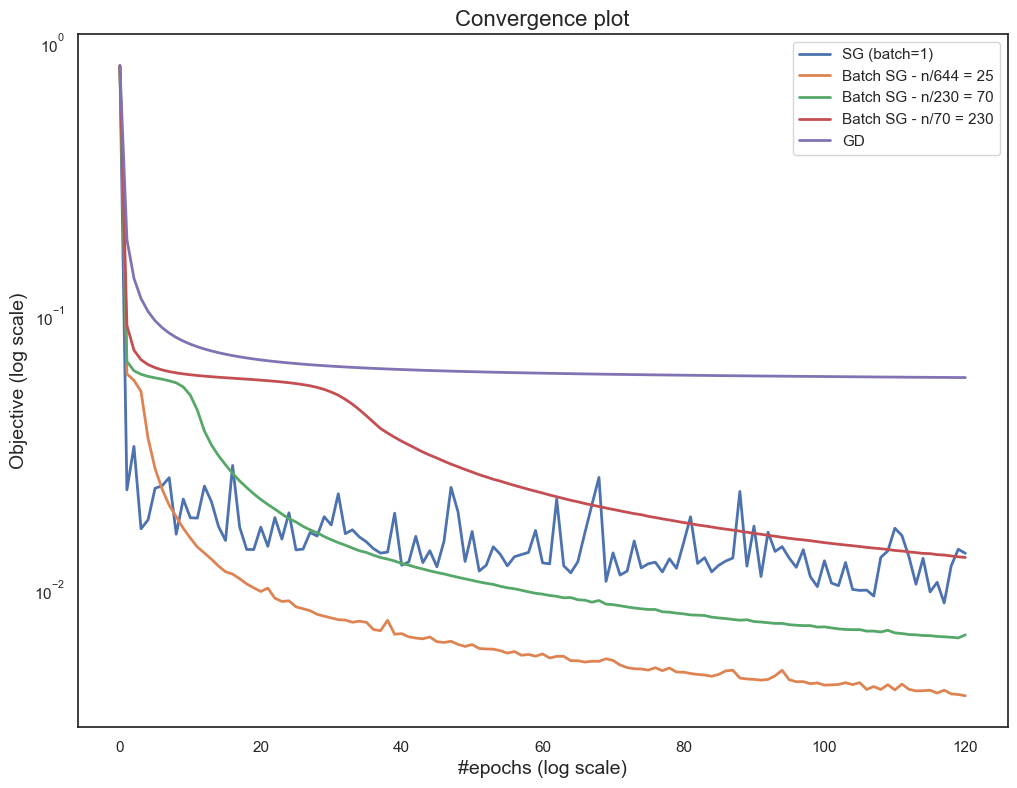

In [299]:
# Plot the comparison of variants of batch SGD with the same stepsize rule
print(binclass_a7a.fun(x_a))

# In terms of objective value (logarithmic scale)
plt.figure(figsize=(12, 9))
plt.semilogy(obj_sg1-f_min, label="SG (batch=1)", lw=2)
plt.semilogy(obj_a-f_min, label="Batch SG - n/644 = 25", lw=2)
plt.semilogy(obj_b-f_min, label="Batch SG - n/230 = 70", lw=2)
plt.semilogy(obj_c-f_min, label="Batch SG - n/70 = 230", lw=2)
plt.semilogy(obj_gd1-f_min, label="GD", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()

## Question 4 - Batch Stochastic Quasi-Newton Method

I will now implement a batch stochastic Quasi-Newton method using the BFGS formula provided in the project instructions. This allows me to test any possible batch size, including that corresponding to a full Quasi-Newton method. I will compare these methods on my binary classification problem.

In [342]:
# BFGS quasi-Newton formula update
def bfgs_update(H_k, s_k, v_k):
    if np.inner(s_k, v_k) > 0:
        rho_k = 1.0 / np.inner(s_k, v_k)
        I = np.eye(len(s_k))
        V = np.outer(v_k, s_k)
        H_k = (I - rho_k * V) @ H_k @ (I - rho_k * V.T) + rho_k * np.outer(s_k, s_k.T)
    return H_k


# limited-memory BFGS (L-BFGS) quasi-Newton formula update
def l_bfgs_update(m, old_pairs, H_k, s_k, v_k):
    if np.inner(s_k, v_k) > 0:
        if len(old_pairs) >= m:
            old_pairs.pop(0)
        old_pairs.append((s_k, v_k))

        # initialize H_kplus1 as the identity matrix
        H_kplus1 = np.eye(len(s_k))  

        for s, v in reversed(old_pairs):
            rho = 1 / np.dot(v, s)
            V = np.outer(v, s)
            H_kplus1 = (np.eye(len(s)) - rho * V) @ H_kplus1 @ (np.eye(len(s)) - rho * V.T) + rho * np.outer(s, s)

        return H_kplus1, old_pairs

    return H_k, old_pairs  # if condition not met then return the previous Hessian and the old pairs unchanged


# batch stochastic quasi-Newton method using BFGS or L-BFGS formula update
def stochastic_quasi_newton_bfgs(binclass, xtarget, x0, alpha, batch_size, epsilon=1e-10, max_iter=120, m=10, low_memory=False):
    xk = x0
    old_pairs = []  # list to store the m most recent (s, v) pairs
    H_k = np.eye(binclass.d)  # initial Hessian approximation is the identity matrix
    objvals = []
    normits = []
    gradnorms = []
    
    # print initial quantities of interest
    print("Batch Stochastic Quasi-Newton, batch size=", batch_size, "/", binclass.n)
    print(' | '.join([name.center(8) for name in ["iter", "fval", "normit"]]))
    
    for k in range(max_iter):
        # using different random seeds to get best convergence, since random indices can affect 
        # unstable convergence and cause divergence
        if low_memory:
            np.random.seed(1)
        else:
            np.random.seed(2)
        
        # select random batch of indices
        indices = np.random.choice(binclass.n, batch_size, replace=False)
        # compute stochastic gradient using only the selected batch
        grad_f_x = np.mean([binclass.grad_i(i, xk) for i in indices], axis=0)
        
        if np.linalg.norm(grad_f_x) < epsilon:
            break
        
        p_k = -H_k.dot(grad_f_x)
        x_new = xk + alpha * p_k
        
        # compute stochastic gradient at the new point x_new for the same batch
        grad_f_x_new = np.mean([binclass.grad_i(i, x_new) for i in indices], axis=0)
        
        s_k = x_new - xk
        v_k = grad_f_x_new - grad_f_x
        
        # if computing low-memory BFGS, use L-BFGS function to update the Hessian
        if low_memory:
            # Update H_k using the L-BFGS update function
            H_k, old_pairs = l_bfgs_update(m, old_pairs, H_k, s_k, v_k)
        else:
            H_k = bfgs_update(H_k, s_k, v_k)
        
        # keep track of objective values and norm difference for plotting
        xk = x_new
        obj = binclass.fun(xk)
        nmin = norm(xk - xtarget)
        objvals.append(obj)
        normits.append(nmin)
        
        # keep track of norms of gradient of xk values for the metric comparison in Question 6
        grad = binclass.grad(xk)
        grad_norm = np.linalg.norm(grad)
        gradnorms.append(grad_norm)
        
        # print result after each iteration
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))

    return xk, np.array(objvals), np.array(normits), np.array(gradnorms)

### Batch Stochastic Quasi-Newton method with BFGS formula

Run for 120 epochs to compare with low-memory and batch stochastic gradient.

In [343]:
x0 = np.zeros(binclass_a7a.d)
alpha = 0.1 / binclass_a7a.lipgrad()
nbset = 25

# find the minimum
x_min_qn, objvals_qn, normits_qn, gradnorms_qn = stochastic_quasi_newton_bfgs(binclass_a7a, x_min, x0, 
                                                                              alpha, batch_size=100)
x_min_fqn, objvals_fqn, normits_fqn, gradnorms_fqn = stochastic_quasi_newton_bfgs(binclass_a7a, x_min, x0, 
                                                                                  alpha, batch_size=binclass_a7a.n)


# print final objective value
objective_value = binclass_a7a.fun(x_min_qn)
print(f"The objective value at x_min is: {objective_value}")

Batch Stochastic Quasi-Newton, batch size= 100 / 16100
  iter   |   fval   |  normit 
       0 | 1.66e+00 | 2.10e+02
       1 | 1.56e+00 | 2.10e+02
       2 | 1.50e+00 | 2.10e+02
       3 | 1.45e+00 | 2.10e+02
       4 | 1.41e+00 | 2.10e+02
       5 | 1.38e+00 | 2.10e+02
       6 | 1.35e+00 | 2.10e+02
       7 | 1.32e+00 | 2.10e+02
       8 | 1.30e+00 | 2.10e+02
       9 | 1.28e+00 | 2.10e+02
      10 | 1.26e+00 | 2.10e+02
      11 | 1.24e+00 | 2.10e+02
      12 | 1.23e+00 | 2.10e+02
      13 | 1.21e+00 | 2.10e+02
      14 | 1.20e+00 | 2.10e+02
      15 | 1.18e+00 | 2.10e+02
      16 | 1.17e+00 | 2.10e+02
      17 | 1.16e+00 | 2.10e+02
      18 | 1.15e+00 | 2.10e+02
      19 | 1.14e+00 | 2.10e+02
      20 | 1.13e+00 | 2.10e+02
      21 | 1.12e+00 | 2.10e+02
      22 | 1.12e+00 | 2.10e+02
      23 | 1.11e+00 | 2.10e+02
      24 | 1.10e+00 | 2.10e+02
      25 | 1.10e+00 | 2.10e+02
      26 | 1.09e+00 | 2.10e+02
      27 | 1.08e+00 | 2.10e+02
      28 | 1.08e+00 | 2.10e+02
      29 | 1.08

C:\Users\jules\AppData\Local\Temp\ipykernel_11816\1720879661.py:40: RuntimeWarning: overflow encountered in power
  denom = (1 + exp_Aix) ** 3
C:\Users\jules\AppData\Local\Temp\ipykernel_11816\1720879661.py:31: RuntimeWarning: overflow encountered in power
  denom = (1 + exp_Aix) ** 3


     114 | 2.79e+00 | 2.50e+02


C:\Users\jules\AppData\Local\Temp\ipykernel_11816\1720879661.py:17: RuntimeWarning: overflow encountered in exp
  f = (self.y - 1/(1+np.exp(-Ax))) ** 2


     115 | 1.00e+00 | 1.92e+04
The objective value at x_min is: 1.2293276616756612


[]

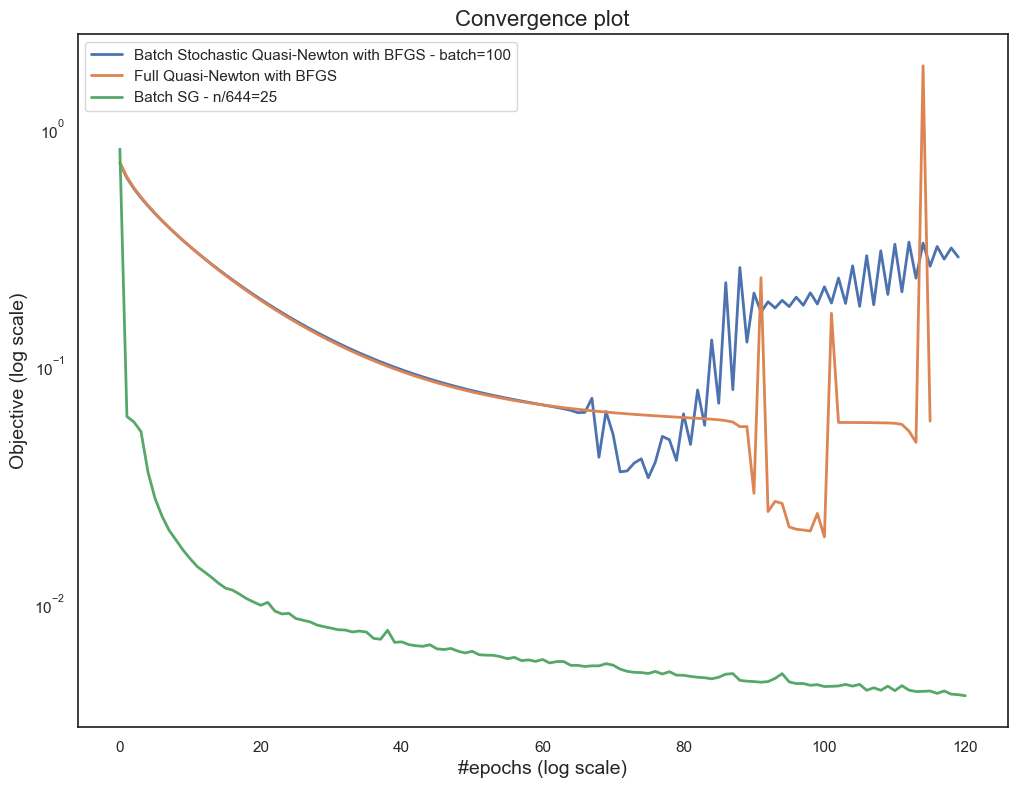

In [344]:
# plot convergence curve to compare with best batch stochastic gradient curve from Question 3 
plt.figure(figsize=(12, 9))
plt.semilogy(objvals_qn-f_min, label="Batch Stochastic Quasi-Newton with BFGS - batch=100", lw=2)
plt.semilogy(objvals_fqn-f_min, label="Full Quasi-Newton with BFGS", lw=2)
plt.semilogy(obj_a-f_min, label="Batch SG - n/644=25", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()
plt.plot()

Run batch stochastic quasi-Newton method for 80 epochs instead to view convergence.

Batch Stochastic Quasi-Newton, batch size= 100 / 16100
  iter   |   fval   |  normit 
       0 | 1.66e+00 | 2.10e+02
       1 | 1.56e+00 | 2.10e+02
       2 | 1.50e+00 | 2.10e+02
       3 | 1.45e+00 | 2.10e+02
       4 | 1.41e+00 | 2.10e+02
       5 | 1.38e+00 | 2.10e+02
       6 | 1.35e+00 | 2.10e+02
       7 | 1.32e+00 | 2.10e+02
       8 | 1.30e+00 | 2.10e+02
       9 | 1.28e+00 | 2.10e+02
      10 | 1.26e+00 | 2.10e+02
      11 | 1.24e+00 | 2.10e+02
      12 | 1.23e+00 | 2.10e+02
      13 | 1.21e+00 | 2.10e+02
      14 | 1.20e+00 | 2.10e+02
      15 | 1.18e+00 | 2.10e+02
      16 | 1.17e+00 | 2.10e+02
      17 | 1.16e+00 | 2.10e+02
      18 | 1.15e+00 | 2.10e+02
      19 | 1.14e+00 | 2.10e+02
      20 | 1.13e+00 | 2.10e+02
      21 | 1.12e+00 | 2.10e+02
      22 | 1.12e+00 | 2.10e+02
      23 | 1.11e+00 | 2.10e+02
      24 | 1.10e+00 | 2.10e+02
      25 | 1.10e+00 | 2.10e+02
      26 | 1.09e+00 | 2.10e+02
      27 | 1.08e+00 | 2.10e+02
      28 | 1.08e+00 | 2.10e+02
      29 | 1.08

[]

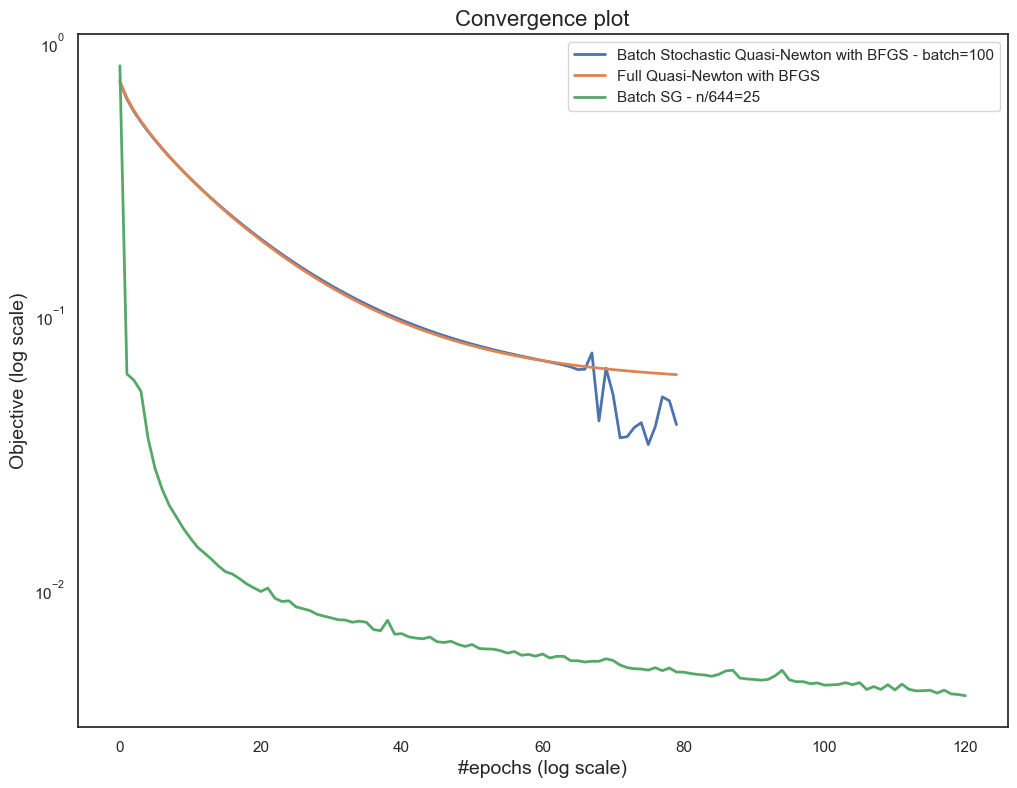

In [345]:
x0 = np.zeros(binclass_a7a.d)
alpha = 0.1 / binclass_a7a.lipgrad()
nbset = 25

# find the minimum
x_min_qn_80, objvals_qn_80, normits_qn_80, gradnorms_qn_80 = stochastic_quasi_newton_bfgs(binclass_a7a, x_min, x0, alpha, 
                                                                                          batch_size=100, max_iter=80)
x_min_fqn_80, objvals_fqn_80, normits_fqn_80, gradnorms_fqn_80 = stochastic_quasi_newton_bfgs(binclass_a7a, x_min, x0, alpha, 
                                                                                              batch_size=binclass_a7a.n, max_iter=80)


# print final objective value
objective_value = binclass_a7a.fun(x_min_qn)
print(f"The objective value at x_min is: {objective_value}")

# plot convergence curve to compare with best batch stochastic gradient curve from Question 3 
plt.figure(figsize=(12, 9))
plt.semilogy(objvals_qn_80-f_min, label="Batch Stochastic Quasi-Newton with BFGS - batch=100", lw=2)
plt.semilogy(objvals_fqn_80-f_min, label="Full Quasi-Newton with BFGS", lw=2)
plt.semilogy(obj_a-f_min, label="Batch SG - n/644=25", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()
plt.plot()

## Question 5 - Limited-memory BFGS (L-BFGS)

### Batch Stochastic Quasi-Newton method with L-BFGS formula

In [346]:
# initialize first guess for x
x0 = np.zeros(binclass_a7a.d)
alpha = 0.1 / binclass_a7a.lipgrad()
batch_size = 100

# test different memory values where m is the number of (s, v) pairs to remember for L-BFGS
# memory = 0
x_min_l_qn, objvals_l_qn, normits_l_qn, gradnorms_l_qn = stochastic_quasi_newton_bfgs(binclass_a7a, x_min, x0, alpha, 
                                                                                      batch_size, m=1, low_memory=True)
# memory = 5
x_min_l_qn_5, objvals_l_qn_5, normits_l_qn_5, gradnorms_l_qn_5 = stochastic_quasi_newton_bfgs(binclass_a7a, x_min, x0, alpha, 
                                                                                              batch_size, m=5, low_memory=True)
# memory = 10
x_min_l_qn_10, objvals_l_qn_10, normits_l_qn_10, gradnorms_l_qn_10 = stochastic_quasi_newton_bfgs(binclass_a7a, x_min, x0, alpha, 
                                                                                                  batch_size, m=10, low_memory=True)

# full quasi-newton with memory = 5
x_min_l_fqn_5, objvals_l_fqn_5, normits_l_fqn_5, gradnorms_l_fqn_5 = stochastic_quasi_newton_bfgs(binclass_a7a, x_min, x0, alpha, 
                                                                                                  batch_size=binclass_a7a.n, m=5, low_memory=True)


# print final objective value
objective_value = binclass_a7a.fun(x_min_l_qn_5)
print(f"The objective value at x_min is: {objective_value}")

Batch Stochastic Quasi-Newton, batch size= 100 / 16100
  iter   |   fval   |  normit 
       0 | 1.65e+00 | 2.10e+02
       1 | 1.55e+00 | 2.10e+02
       2 | 1.49e+00 | 2.10e+02
       3 | 1.44e+00 | 2.10e+02
       4 | 1.40e+00 | 2.10e+02
       5 | 1.37e+00 | 2.10e+02
       6 | 1.34e+00 | 2.10e+02
       7 | 1.31e+00 | 2.10e+02
       8 | 1.29e+00 | 2.10e+02
       9 | 1.27e+00 | 2.10e+02
      10 | 1.25e+00 | 2.10e+02
      11 | 1.23e+00 | 2.10e+02
      12 | 1.21e+00 | 2.10e+02
      13 | 1.20e+00 | 2.10e+02
      14 | 1.19e+00 | 2.10e+02
      15 | 1.17e+00 | 2.10e+02
      16 | 1.16e+00 | 2.10e+02
      17 | 1.15e+00 | 2.10e+02
      18 | 1.14e+00 | 2.10e+02
      19 | 1.13e+00 | 2.10e+02
      20 | 1.12e+00 | 2.10e+02
      21 | 1.12e+00 | 2.10e+02
      22 | 1.11e+00 | 2.10e+02
      23 | 1.10e+00 | 2.10e+02
      24 | 1.09e+00 | 2.10e+02
      25 | 1.09e+00 | 2.10e+02
      26 | 1.08e+00 | 2.10e+02
      27 | 1.08e+00 | 2.10e+02
      28 | 1.07e+00 | 2.10e+02
      29 | 1.07

[]

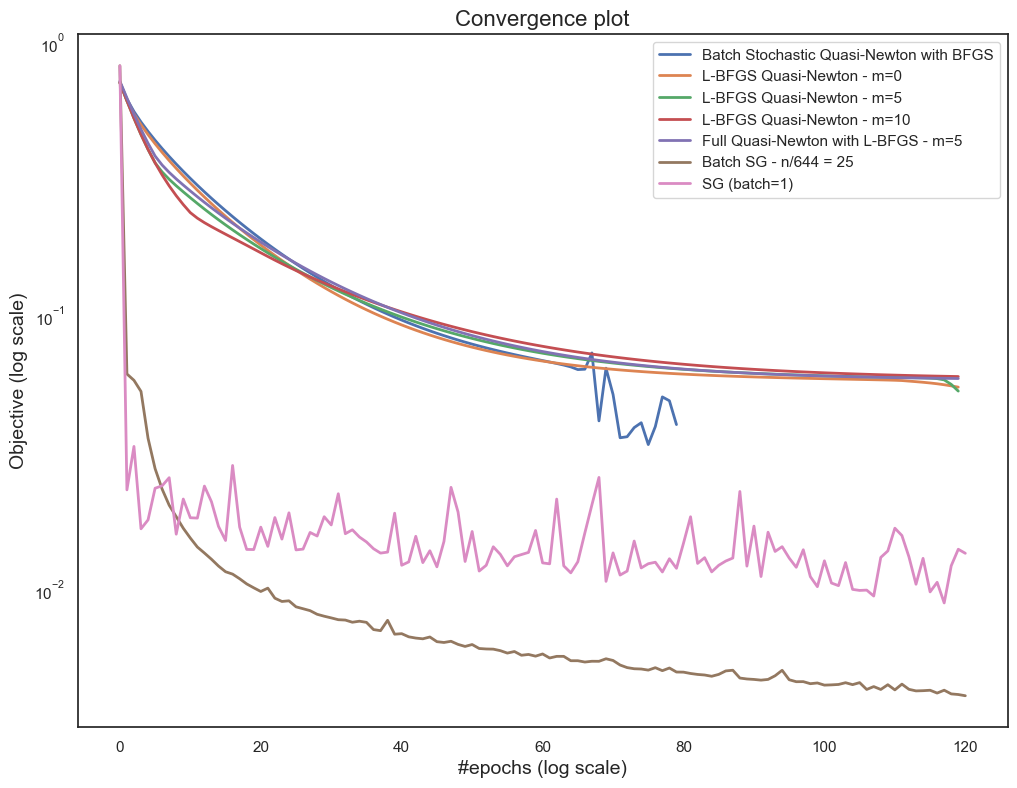

In [347]:
# plot all the final convergence curves for comparison
plt.figure(figsize=(12, 9))
plt.semilogy(objvals_qn_80-f_min, label="Batch Stochastic Quasi-Newton with BFGS", lw=2)
plt.semilogy(objvals_l_qn-f_min, label="L-BFGS Quasi-Newton - m=0", lw=2)
plt.semilogy(objvals_l_qn_5-f_min, label="L-BFGS Quasi-Newton - m=5", lw=2)
plt.semilogy(objvals_l_qn_10-f_min, label="L-BFGS Quasi-Newton - m=10", lw=2)
plt.semilogy(objvals_l_fqn_5-f_min, label="Full Quasi-Newton with L-BFGS - m=5", lw=2)
plt.semilogy(obj_a-f_min, label="Batch SG - n/644 = 25", lw=2)
plt.semilogy(obj_sg1-f_min, label="SG (batch=1)", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()
plt.plot()

## Question 6 - Metric Comparison

For the comparison of both the full-memory and low-memory version of quasi-Newton, I will use the gradient norm metric, and plot the convergence of gradient norms during the optimization process.

In [354]:
# L-BFGS with memory = 5 for 80 epochs in order to compare gradient norms
x_min_l_qn_5_80, objvals_l_qn_5_80, normits_l_qn_5_80, gradnorms_l_qn_5_80 = stochastic_quasi_newton_bfgs(binclass_a7a, x_min, x0, alpha, 
                                                                                              batch_size, m=5, low_memory=True, max_iter=80)

Batch Stochastic Quasi-Newton, batch size= 100 / 16100
  iter   |   fval   |  normit 
       0 | 1.65e+00 | 2.10e+02
       1 | 1.55e+00 | 2.10e+02
       2 | 1.47e+00 | 2.10e+02
       3 | 1.40e+00 | 2.10e+02
       4 | 1.35e+00 | 2.10e+02
       5 | 1.30e+00 | 2.10e+02
       6 | 1.28e+00 | 2.10e+02
       7 | 1.26e+00 | 2.10e+02
       8 | 1.24e+00 | 2.10e+02
       9 | 1.23e+00 | 2.10e+02
      10 | 1.21e+00 | 2.10e+02
      11 | 1.20e+00 | 2.10e+02
      12 | 1.19e+00 | 2.10e+02
      13 | 1.18e+00 | 2.10e+02
      14 | 1.17e+00 | 2.10e+02
      15 | 1.16e+00 | 2.10e+02
      16 | 1.15e+00 | 2.10e+02
      17 | 1.14e+00 | 2.10e+02
      18 | 1.13e+00 | 2.10e+02
      19 | 1.12e+00 | 2.10e+02
      20 | 1.12e+00 | 2.10e+02
      21 | 1.11e+00 | 2.10e+02
      22 | 1.11e+00 | 2.10e+02
      23 | 1.10e+00 | 2.10e+02
      24 | 1.09e+00 | 2.10e+02
      25 | 1.09e+00 | 2.10e+02
      26 | 1.08e+00 | 2.10e+02
      27 | 1.08e+00 | 2.10e+02
      28 | 1.08e+00 | 2.10e+02
      29 | 1.07

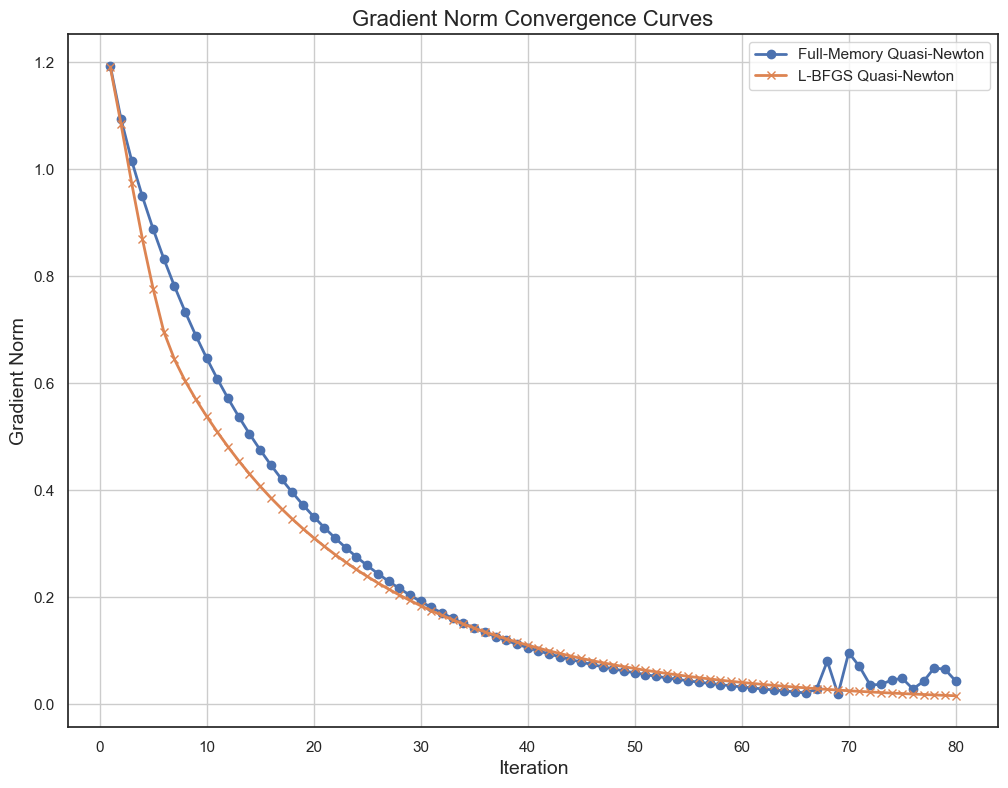

In [358]:
# plotting the gradient norm metric comparison between the two methods

iterations = range(1, len(gradnorms_qn_80) + 1)
plt.figure(figsize=(12, 9))
# plotting the full-memory quasi-Newton convergence curve
plt.plot(iterations, gradnorms_qn_80, label='Full-Memory Quasi-Newton', marker='o', lw=2)
# plotting the L-BFGS convergence curve
plt.plot(iterations, gradnorms_l_qn_5_80, label='L-BFGS Quasi-Newton', marker='x', lw=2)
plt.title('Gradient Norm Convergence Curves', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Gradient Norm', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()